# Instance Segmentation with MMDET

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/SwinTransformer/Swin-Transformer-Object-Detection.git
!pip install pytube
!pip install mediapipe
!pip install dlib==19.18
!pip install face-recognition
# !unzip "/content/drive/MyDrive/frames.zip"
# !unzip "/content/drive/MyDrive/landmarks_compressed.json.zip"

In [1]:
from pytube import YouTube
import cv2
import pickle
from scipy import sparse
import face_recognition
from google.colab.patches import cv2_imshow
from glob import glob
import mediapipe as mp
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from mediapipe.framework.formats.landmark_pb2 import NormalizedLandmarkList
import random

## Downloading YT video and converting to individual frames

In [4]:
#https://www.youtube.com/watch?v=v14PWuURC7Y&list=PLnS-KSZtIXlH8YNow_rTIflrX6ZEF1uNd
#Friends: Rachel Runs Out on her Wedding to Barry (Season 1 Clip) | TBS
!mkdir /content/frames
yt = YouTube('https://www.youtube.com/watch?v=v14PWuURC7Y&list=PLnS-KSZtIXlH8YNow_rTIflrX6ZEF1uNd').streams[3].download('/content')
vidcap = cv2.VideoCapture('/content/Friends Rachel Runs Out on her Wedding to Barry (Season 1 Clip)  TBS.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  if not count % 1000:
    print(count)
  count += 1


0
1000
2000
3000
4000


## Imports and Data Reads

In [2]:
people_name = ["chandler", "pheobe", "monica", "joey", "ross", "rachel", "unknown"]
people_color = [(0, 0, 100) , (100,0,0), (0,0,0), (155,155,155), (100,100,0), (155,100,0), (0,128,0) ]
text_color = (173, 216, 230)

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

with open("/content/drive/MyDrive/Kliky/co_ordinates.json") as fp:
  data = fp.read()
  co_ords = json.loads(data)
# with open("/content/landmarks_compressed.json") as fp:
#   data = fp.read()
#   final_cords = json.loads(data)

path_to_frames = "/content/frames"
sorted_paths_to_frames = sorted(glob("/content/frames/*.jpg") , key = lambda x: int(x.split("/")[-1].replace(".jpg","").replace("frame","")) ) 

### Sample Frame

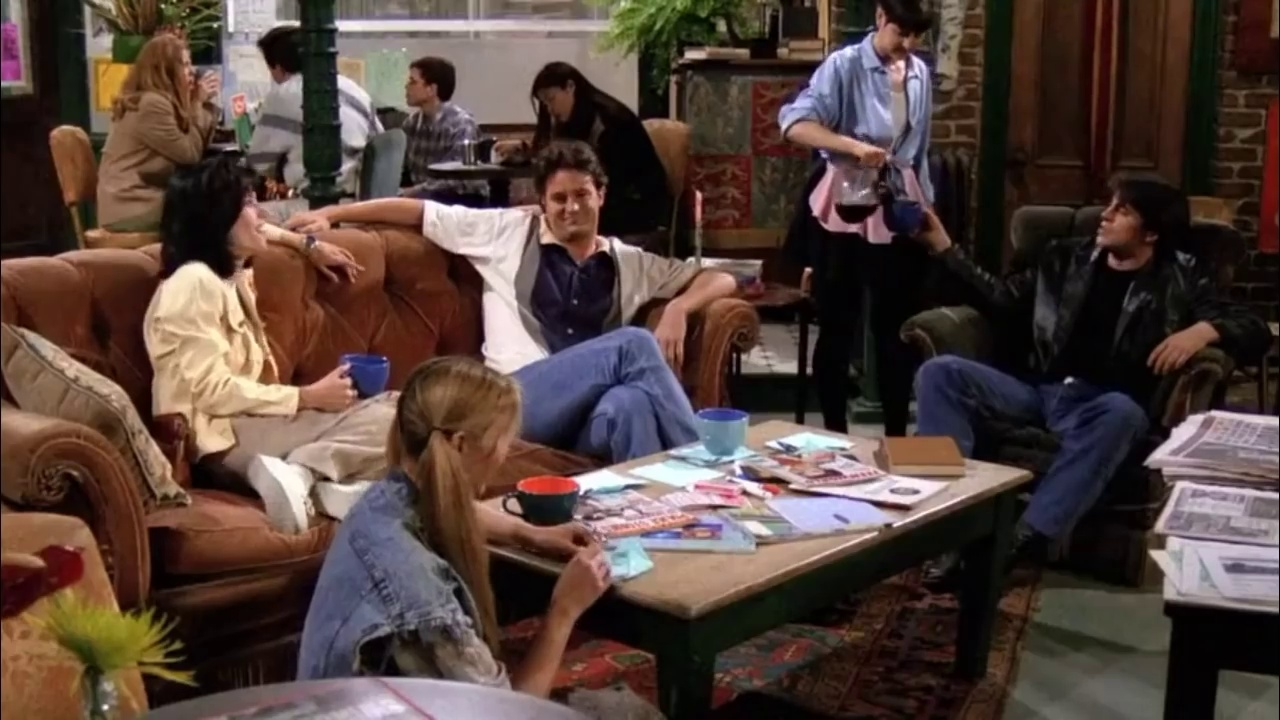

In [ ]:
img = cv2.imread("/content/frames/frame1255.jpg")
cv2_imshow(img)

In [17]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# !pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
# !pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
# !cp /content/drive/MyDrive/Kliky/image.py /content/mmdetection/mmdet/core/visualization
%cd mmdetection

# !pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
# !pip install Pillow==7.0.0

Cloning into 'mmdetection'...
remote: Enumerating objects: 31759, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (255/255), done.
Receiving objects: 100% (31759/31759), 40.93 MiB | 491.00 KiB/s, done.
remote: Total 31759 (delta 105), reused 266 (delta 84), pack-reused 31420
Resolving deltas: 100% (22725/22725), done.
/Users/ramishrasool/Desktop/Kliky/Landmark Extraction/duplicate/mmdetection


In [7]:
# Check Pytorch installation
import torch, torchvision
from mmdet.core.visualization.image import imshow_det_bboxes
import mmcv
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.13.0.dev20220928 False
2.25.2
not available
clang 14.0.0


In [ ]:
1.5.1+cu101 True
2.25.2
11.1
GCC 7.5

In [15]:
!ls

Friends Rachel Runs Out on her Wedding to Barry (Season 1 Clip)  TBS.mp4
InstanceSegmenation_with_Holistic_Landmark_Extraction.ipynb
Untitled.ipynb
co_ordinates.json
detection
face_recognition
frames
friends_cast
misc.ipynb
mmdetection
run.py


## Perform inference with a MMDet detector
Downloading model checkpoint

In [7]:
!mkdir checkpoints
!wget -c http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2022-09-27 06:03:34--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.89.140.65
Connecting to download.openmmlab.com (download.openmmlab.com)|47.89.140.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  9.43MB/s    in 18s     

2022-09-27 06:03:53 (9.19 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [16]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'mmdetection/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

load checkpoint from local path: mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


FileNotFoundError: mmdetection/checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth can not be found.

In [ ]:
VIDEO_FILE = "/content/mmdetection/demo/demo.mp4"
SCORE_THR = 0.8
OUT_FILE = "/content/processed.mp4"

### Instance Segmentation on Video

In [ ]:
!python mmdetection/demo/video_demo.py \
    "/content/Friends season 1 episode 1 part 1.mp4" \
    'mmdetection/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py' \
    'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth' \
    --score-thr 0.8 \
    --out "/content/processed.mp4"

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
[                                                  ] 0/9001, elapsed: 0s, ETA:/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
[>>] 9001/9001, 2.7 task/s, elapsed: 3335s, ETA:     0s


### Changing Source Code

### Sample instance segmented frame

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


(8, 1080, 1920) (8, 5)


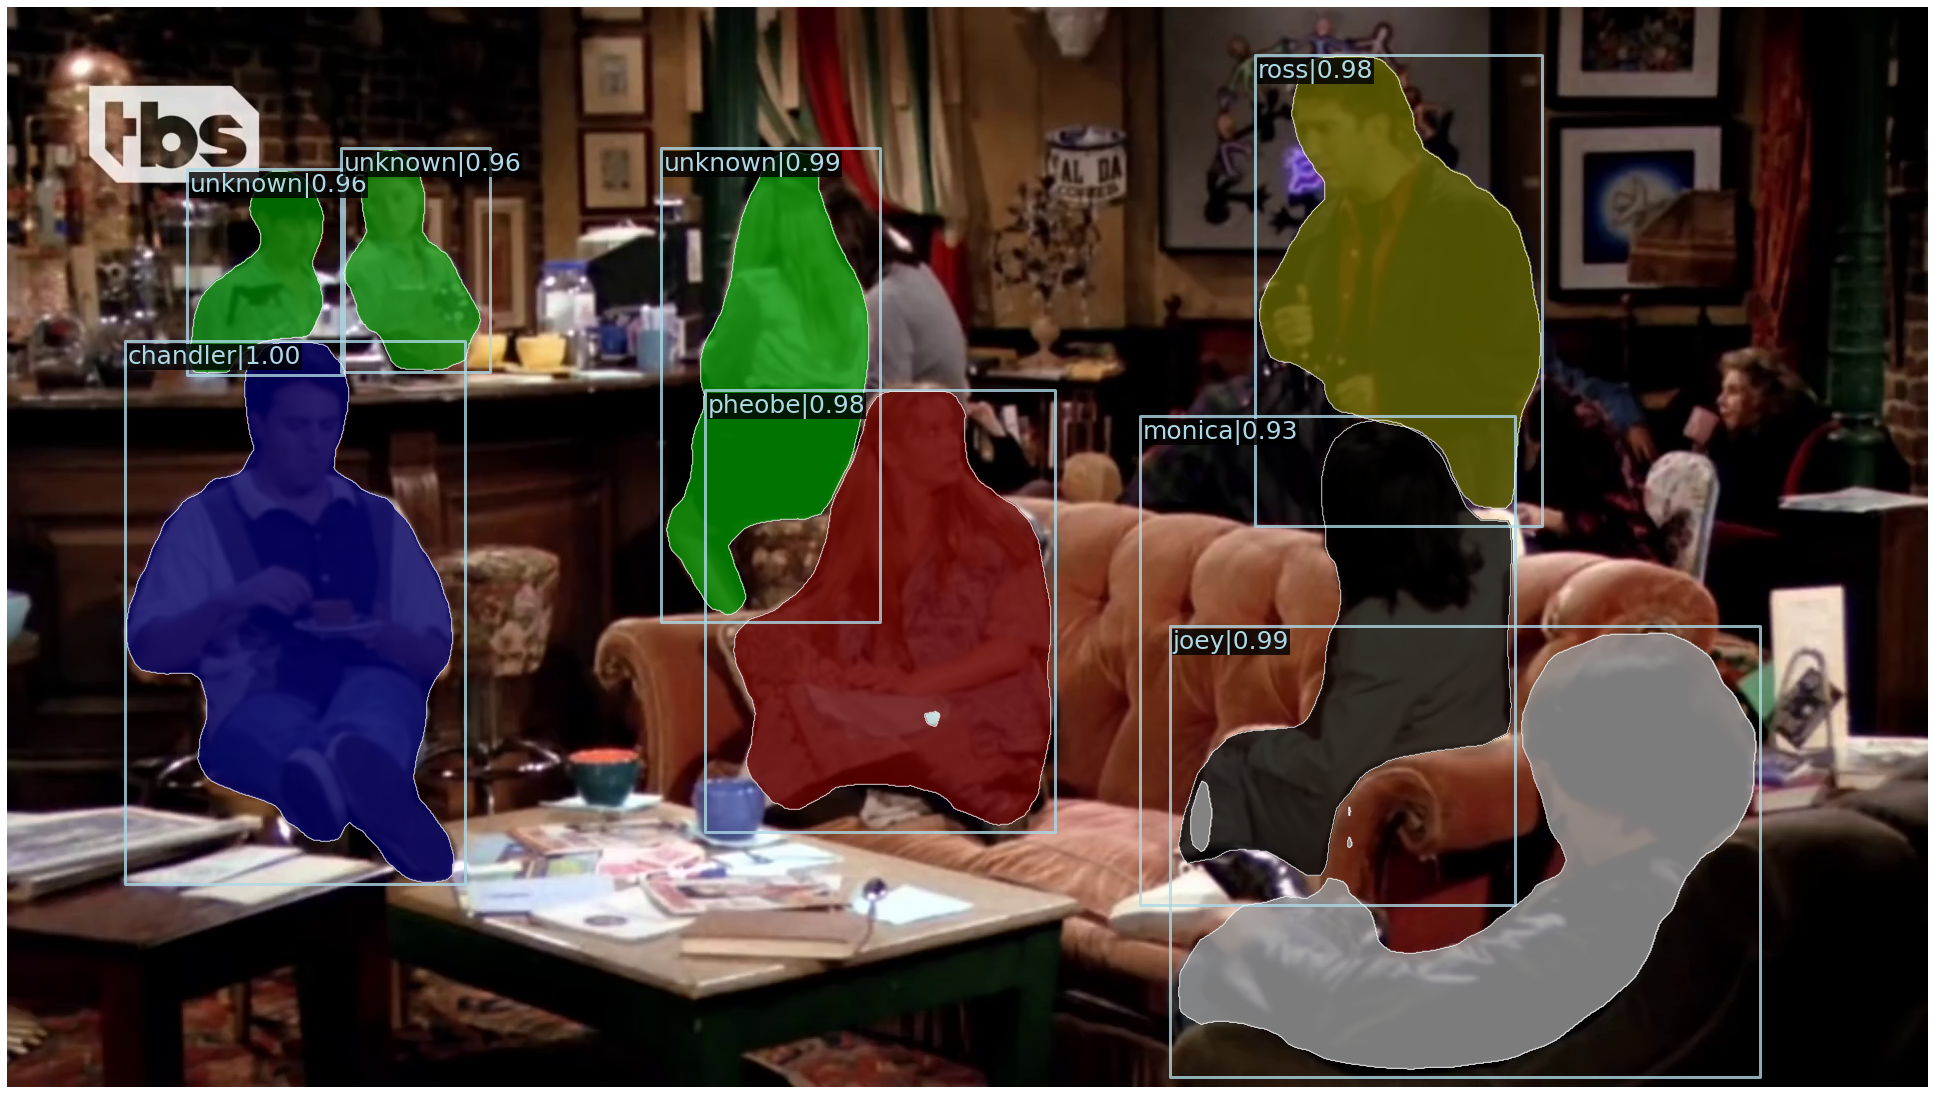

In [5]:
img_path = "/content/frames/frame0.jpg"
result = inference_detector(model, img_path)
labs = np.array([0, 6, 6, 6, 1, 2, 3, 4 ])
color = np.array([ people_color[x] for x in labs ])

person_detected = sum(result[0][0][:,4] > 0.8)
segm_result = result[1][0][:person_detected]
segms = np.stack(np.array(segm_result), axis=0)
bboxes = np.vstack(result[0][0][:person_detected])
bbox_sort = bboxes[:, 0].argsort()
bboxes = bboxes[bbox_sort]
segms = segms[bbox_sort]

print(segms.shape, bboxes.shape)
imshow_det_bboxes(mmcv.imread(img_path), bbox_color=text_color, text_color=text_color , mask_color = color , class_names = people_name ,  thickness=3 ,  font_size = 25, bboxes = bboxes , score_thr = 0.0, labels = labs, segms = segms )
pass

In [ ]:
len(result[1]), type(result[1][0]), len(result[1][0]) , 
bboxes[bboxes[:, 0].argsort()]

array([[1.1706509e+02, 3.3472720e+02, 4.5781235e+02, 8.7757306e+02,
        9.9726868e-01],
       [1.7987614e+02, 1.6245818e+02, 3.3678494e+02, 3.6866217e+02,
        9.5878506e-01],
       [3.3368948e+02, 1.4103716e+02, 4.8209113e+02, 3.6547577e+02,
        9.5903260e-01],
       [6.5399255e+02, 1.4154555e+02, 8.7231012e+02, 6.1586279e+02,
        9.8592389e-01],
       [6.9759247e+02, 3.8352667e+02, 1.0471464e+03, 8.2573975e+02,
        9.8457181e-01],
       [1.1329780e+03, 4.0903012e+02, 1.5070995e+03, 8.9884955e+02,
        9.3431050e-01],
       [1.1626147e+03, 6.1972278e+02, 1.7527202e+03, 1.0705012e+03,
        9.8705381e-01],
       [1.2474982e+03, 4.8307194e+01, 1.5349727e+03, 5.1992902e+02,
        9.8291576e-01]], dtype=float32)

### Extracting person bbox from the detection

(720, 1280, 3)


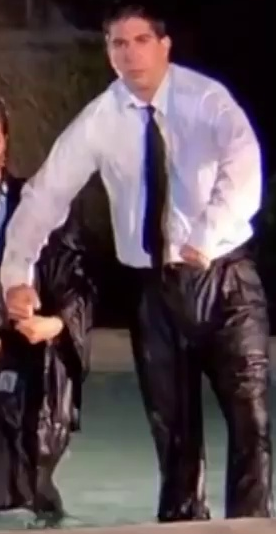

In [ ]:
import matplotlib.pyplot as plt
img = cv2.imread(img_path)
print(img.shape)
cv2_imshow(img[155:689,759:1035])

In [ ]:
arr = result[0][0][result[0][0][:,4] > 0.8].astype(int)
arr = arr[arr[:, 0].argsort()]
arr

array([[ 176,  198,  402,  699,    0],
       [ 358,  266,  518,  696,    0],
       [ 470,  241,  676,  684,    0],
       [ 619,  205,  708,  382,    0],
       [ 653,  244,  789,  686,    0],
       [ 759,  155, 1035,  689,    0]])

In [ ]:
!zip -r '/content/"frames.zip"' '/content/frames'

### Saving bbox co-ordinates for each person detection from each frame in JSON

In [ ]:
co_ords = {}
for ind,img_path in enumerate(sorted_paths_to_frames):
    name = img_path.split("/")[-1]
    result = inference_detector(model, img_path) # compute segmentation and bbox
    arr = result[0][0][result[0][0][:,4] > 0.8].astype(int) # extract people from detections
    segments = result[1][0][:sum(result[0][0][:,4] > 0.8)]
    arr = arr[arr[:, 0].argsort()]
    co_ords[name] = arr.tolist()
    if ind % 500 == 0 or ind == len(sorted_paths_to_frames)-1:
      print(name)
      with open("/content/drive/MyDrive/Kliky/co_ordinates.json", "w") as fp:
        json.dump(co_ords, fp , indent = 4)

frame4500.jpg


In [ ]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.8, out_file = "/content/detection/"+path.split("/")[-1] )

In [ ]:
model.show_result(
        img,
        result,
        score_thr=0.8,
        show=True,
        wait_time=0,
        win_name=None,
        bbox_color=None,
        text_color=(200, 200, 200),
        mask_color=None,
        out_file="/content/abc.jpg")

## Mediapipe For Holistic Landmark Extraction

frame0.jpg


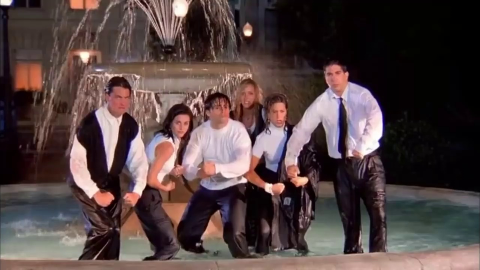

frame1.jpg


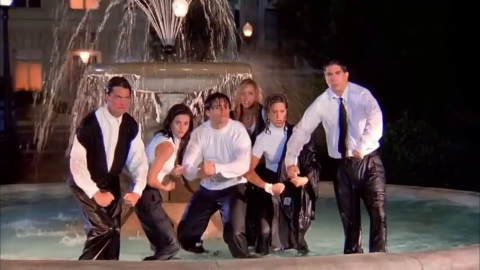

frame10.jpg


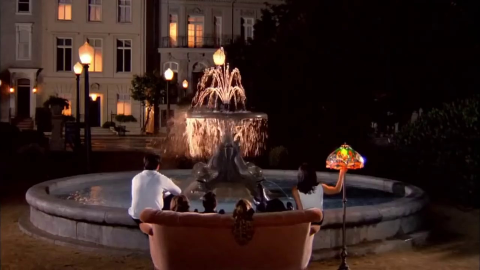

frame100.jpg


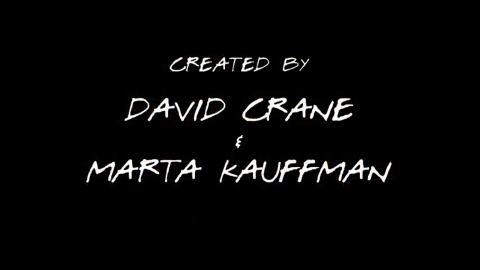

frame1000.jpg


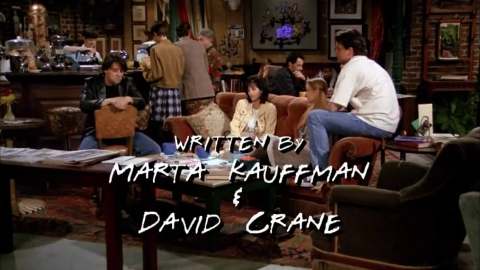

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

# Read images with OpenCV.
# Preview the images.
for name in sorted(glob("/content/frames/*.jpg"))[:5]:
  print(name.split("/")[-1])
  resize_and_show(cv2.imread(name))

Code in the cell below does following:



*   Extracts person detection from each frame using the co-ordinates stored in the JSON saved above
*   Runs it through the Mediapipe API to get face, pose, right and left hand landmarks
*   Saves the corresponding landmarks in a compressed hex format
* Does this for each person in each frame and creates a final JSON





In [ ]:
# Run MediaPipe Holistic and draw pose landmarks.
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

final_cords = {}

with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as holistic:
  for frame_number, img_path in enumerate(sorted_paths_to_frames):
    person = []
    image = cv2.imread(img_path)
    name = img_path.split("/")[-1]
    co_ord = co_ords[name]
    if co_ords == []:
      final_cords[name] = []
      continue
    for person_number, (y,x,y_,x_,_) in enumerate(co_ord):
    # Convert the BGR image to RGB and process it with MediaPipe Pose.
      img = image[x:x_, y:y_]
      results = holistic.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      image_hight, image_width, _ = img.shape
      landmarks = {}
      if results.face_landmarks:
        landmarks["face_landmark"] = results.face_landmarks.SerializeToString().hex()
      else:
        landmarks["face_landmark"] = None

      if results.right_hand_landmarks:
        landmarks["right_hand_landmark"] = results.right_hand_landmarks.SerializeToString().hex()
      else:
        landmarks["right_hand_landmark"] = None

      if results.left_hand_landmarks:
        landmarks["left_hand_landmark"] = results.left_hand_landmarks.SerializeToString().hex()
      else:
        landmarks["left_hand_landmark"] = None

      if results.pose_landmarks:
        landmarks["pose_landmark"] = results.pose_landmarks.SerializeToString().hex()
      else:
        landmarks["pose_landmark"] = None

      landmarks["person_co_ordinate"] = [y,x,y_,x_]
      landmarks["person_image_height_width"] = [image_hight,image_width ]
      person.append(landmarks)
    final_cords[name] = person
    if frame_number % 500 == 0:
      print(name)
      with open("/content/final_cords_bin.json", "w") as fp:
        json.dump(final_cords,fp, indent = 4)
final_cords

frame0.jpg


## Inference

In [ ]:
def extract_and_show_people_from_frame(frame_number, draw_landmark = True, show = False, output = None):
    path = os.path.join(path_to_frames, frame_number)
    img_BGR = cv2.imread(path)
    if show:
      plt.imshow(cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB))
      plt.title(frame_number)
      plt.show()
    for ind, person_info  in enumerate(final_cords[frame_number]):
        y,x,y_,x_ =  person_info["person_co_ordinate"]
        # print(x_-x, y_-y)
        image = cv2.cvtColor(img_BGR[x:x_,y:y_], cv2.COLOR_BGR2RGB)
        if draw_landmark:
          if person_info["left_hand_landmark"]:
            left_hand = NormalizedLandmarkList.FromString(bytes.fromhex(person_info["left_hand_landmark"]))
            mp_drawing.draw_landmarks(image, left_hand, mp_holistic.HAND_CONNECTIONS)
          if person_info["right_hand_landmark"]:
            right_hand = NormalizedLandmarkList.FromString(bytes.fromhex(person_info["right_hand_landmark"]))
            mp_drawing.draw_landmarks(image, right_hand, mp_holistic.HAND_CONNECTIONS)
          if person_info["pose_landmark"]:
            pose = NormalizedLandmarkList.FromString(bytes.fromhex(person_info["pose_landmark"]))
            mp_drawing.draw_landmarks(
              image,
              pose,
              mp_holistic.POSE_CONNECTIONS,
              landmark_drawing_spec=mp_drawing_styles.
              get_default_pose_landmarks_style())
          if person_info["face_landmark"]:
            face = NormalizedLandmarkList.FromString(bytes.fromhex(person_info["face_landmark"]))
            mp_drawing.draw_landmarks(
              image,
              face,
              mp_holistic.FACEMESH_TESSELATION,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_tesselation_style())
          
        img_BGR[x:x_,y:y_] = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if output:
      cv2.imwrite( os.path.join(output, frame_number), img_BGR )

    if show:
      plt.imshow( cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB) )
      
      plt.title(frame_number)
      plt.show()

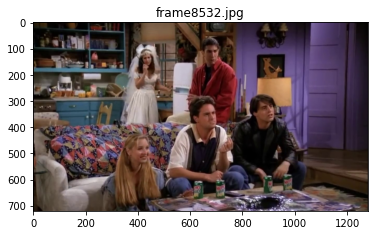

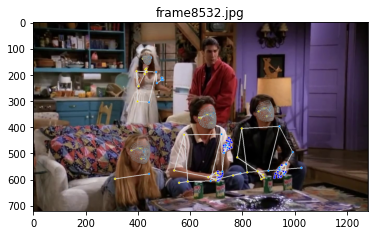

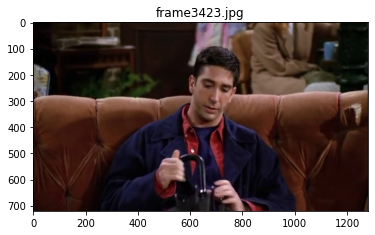

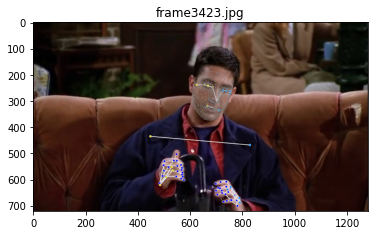

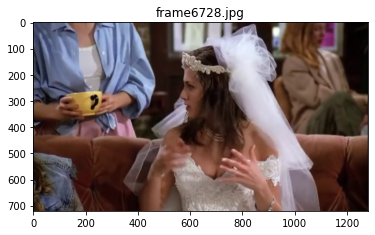

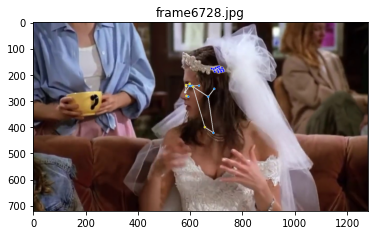

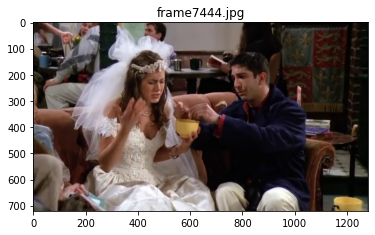

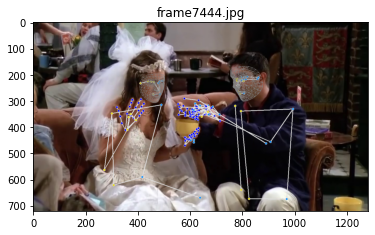

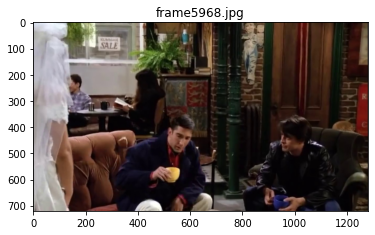

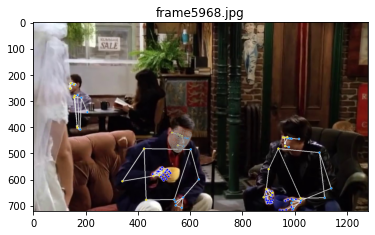

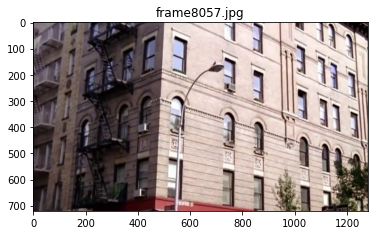

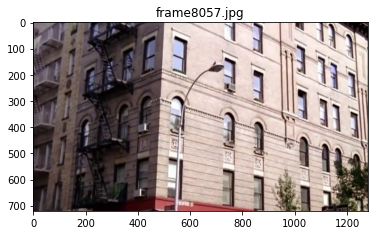

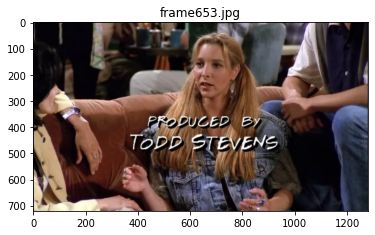

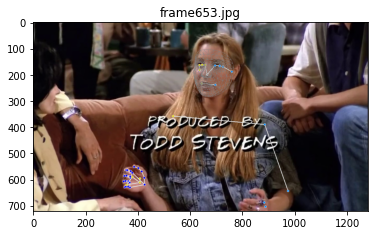

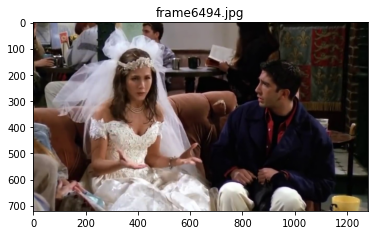

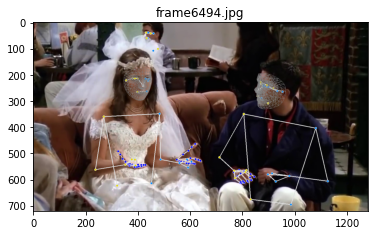

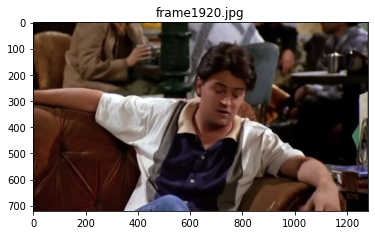

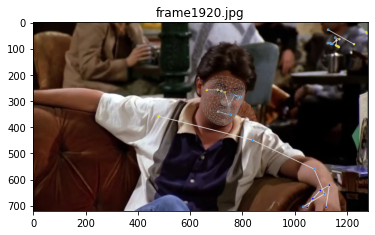

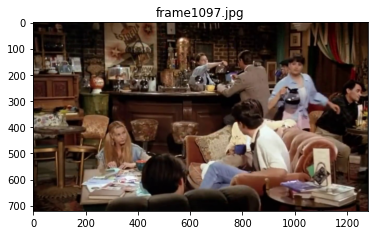

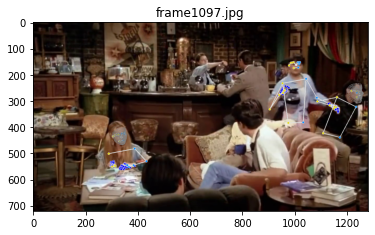

In [ ]:
for x in [random.randint(0,9000) for y in range(10)]:
  extract_and_show_people_from_frame("frame{}.jpg".format(x), show=True)

### Saves all of the frames with holistic landmarks in a folder

In [ ]:
for frame_number, img_path in enumerate(sorted_paths_to_frames):
  if frame_number % 500 == 0:
    print(frame_number)
  extract_and_show_people_from_frame(img_path.split("/")[-1], show = False, output = "/content/processed")

### Converts individual frames into a single video

In [ ]:
sorted_paths_to_processed = sorted(glob("/content/processed/*.jpg") , key = lambda x: int(x.split("/")[-1].replace(".jpg","").replace("frame","")) )

size = (1280,720)

out = cv2.VideoWriter('/content/drive/MyDrive/landmark_video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

for ind , path in enumerate(sorted_paths_to_processed):
  img = cv2.imread(path)
  out.write(img)
out.release()

## Face Recognition

In [7]:
known_image = face_recognition.load_image_file("/content/drive/MyDrive/Kliky/friends_cast/chandler.jpg")
chandler_encoding = face_recognition.face_encodings(known_image, model = "large")[0]
known_image = face_recognition.load_image_file("/content/drive/MyDrive/Kliky/friends_cast/pheobe.jpg")
pheobe_encoding = face_recognition.face_encodings(known_image, model = "large")[0]
known_image = face_recognition.load_image_file("/content/drive/MyDrive/Kliky/friends_cast/ross.jpg")
ross_encoding = face_recognition.face_encodings(known_image, model = "large")[0]
known_image = face_recognition.load_image_file("/content/drive/MyDrive/Kliky/friends_cast/monica.jpg")
monica_encoding = face_recognition.face_encodings(known_image, model = "large")[0]
known_image = face_recognition.load_image_file("/content/drive/MyDrive/Kliky/friends_cast/rachel.jpg")
rachel_encoding = face_recognition.face_encodings(known_image, model = "large")[0]
known_image = face_recognition.load_image_file("/content/drive/MyDrive/Kliky/friends_cast/joey.jpg")
joey_encoding = face_recognition.face_encodings(known_image, model = "large")[0]

TypeError: ignored

In [8]:
# !mkdir /content/detected
def detect_and_save(show = False, frame_number = "frame0.jpg", out_file = None):
  if out_file:
    out_file = "/content/detected/{}".format(frame_number)
  img_BGR = cv2.imread("/content/frames/{}".format(frame_number))
  labs = []
  if show:
    plt.imshow(cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB))
    plt.title(frame_number)
    plt.show()
  for ind, cord  in enumerate((co_ords[frame_number])):
      y = cord[0]
      x = cord[1]
      y_= cord[2]
      x_= cord[3]
      image = cv2.cvtColor(img_BGR[x:x_,y:y_], cv2.COLOR_BGR2RGB)
      if show:
        plt.imshow(image)
        plt.title("Single Detected Person")
        plt.show()
      try:
        unknown_encoding = face_recognition.face_encodings(image, model = "large")[0]
      except:
        labs.append(6)
        continue
      # ["chandler", "pheobe", "monica", "joey", "ross", "rachel", "unknown"]
      results = face_recognition.compare_faces([chandler_encoding, pheobe_encoding, monica_encoding, joey_encoding, ross_encoding, rachel_encoding], unknown_encoding)
      if sum(results) == 0:
        labs.append(np.argmax(results))
        continue
      labs.append(np.argmax(results))

  result = inference_detector(model, "/content/frames/{}".format(frame_number))
  labs = np.array(labs)
  color = np.array([ people_color[x] for x in labs ])

  person_detected = sum(result[0][0][:,4] > 0.8)
  segm_result = result[1][0][:person_detected]
  segms = np.stack(np.array(segm_result), axis=0)
  bboxes = np.vstack(result[0][0][:person_detected])
  bbox_sort = bboxes[:, 0].argsort()
  bboxes = bboxes[bbox_sort]
  segms = segms[bbox_sort]
  discard = imshow_det_bboxes(mmcv.imread("/content/frames/{}".format(frame_number)), show = False ,  out_file = out_file, bbox_color=text_color, text_color=text_color , mask_color = color , class_names = people_name ,  thickness=3 ,  font_size = 25, bboxes = bboxes , score_thr = 0.0, labels = labs, segms = segms)
  return None

In [16]:
for x in range(len(sorted_paths_to_frames)):
  if x % 500 == 0:
    print("frame{}.jpg".format(x))
  detect_and_save( frame_number = "frame{}.jpg".format(x), out_file = True, show = False)

frame0.jpg
frame500.jpg


KeyboardInterrupt: ignored

ValueError: ignored

<Figure size 1920.01x1080.01 with 1 Axes>

In [17]:
!rm -r /content/detected
!mkdir detected

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/en/d/da/Matt_LeBlanc_as_Joey_Tribbiani.jpg -O /content/drive/MyDrive/Kliky/friends_cast/joey.jpg

--2022-09-10 02:03:20--  https://upload.wikimedia.org/wikipedia/en/d/da/Matt_LeBlanc_as_Joey_Tribbiani.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20387 (20K) [image/jpeg]
Saving to: ‘/content/drive/MyDrive/Kliky/friends_cast/joey.jpg’

/content/drive/MyDr 100%[===================>]  19.91K  --.-KB/s    in 0.002s  

2022-09-10 02:03:20 (9.20 MB/s) - ‘/content/drive/MyDrive/Kliky/friends_cast/joey.jpg’ saved [20387/20387]



In [ ]:
import glob
# len(glob.glob("/content/detected/*.jpg"))

In [ ]:
x = sorted(glob.glob("/content/detected/*.jpg") , key = lambda x: int(x.split("/")[-1].replace(".jpg","").replace("frame","")) )

In [ ]:

# for ind,path in enumerate(x):

import cv2
import numpy as np
import glob

# img_array = []
# for filename in x:
#     img = cv2.imread(filename)
#     height, width, layers = img.shape
#     size = (width,height)
#     img_array.append(img)
img = cv2.imread(x[0])
height, width, layers = img.shape
size = (width,height)

out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'MJPG'), 30, size)
 
for filename in x:
    img = cv2.imread(filename)
    out.write(img)
out.release()


In [ ]:
!zip -r /content/drive/MyDrive/Kliky/detected.zip /content/detected

In [ ]:
!cp /content/project.avi /content/drive/MyDrive/Kliky

In [10]:
!nvidia-smi

Tue Sep 27 06:15:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |   3930MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip

#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null

#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')

#Get public address and print connect command
with urllib.request.urlopen('http://localhost:4040/api/tunnels') as response:
  data = json.loads(response.read().decode())
  (host, port) = data['tunnels'][0]['public_url'][6:].split(':')
  print(f'SSH command: ssh -p{port} root@{host}')

#Print root password
print(f'Root password: {password}')

In [6]:
!pip uninstall face_recognition

Found existing installation: face-recognition 1.3.0
Uninstalling face-recognition-1.3.0:
  Would remove:
    /usr/local/bin/face_detection
    /usr/local/bin/face_recognition
    /usr/local/lib/python3.7/dist-packages/face_recognition-1.3.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/face_recognition/*
Proceed (y/n)? y
  Successfully uninstalled face-recognition-1.3.0
